# HEXAGON LIBRARY IN PYTHON

adapted from: https://www.redblobgames.com/grids/hexagons/#map-storage

In [35]:
import random
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import time
import numpy as np
from collections import namedtuple
from collections import Counter

In [36]:
class Hex:
    DIRECTIONS = [
        (1, 0, -1), (1, -1, 0), (0, -1, 1),
        (-1, 0, 1), (-1, 1, 0), (0, 1, -1)
    ]
    
    def __init__(self, q: int, r:int, resource: str = None, token: int = 0):
        self.q = q
        self.r = r
        self.s = - q - r
        self.resource = resource
        self.token = token
        
    def __eq__(self, other):
        if isinstance(other, Hex):
            return self.q == other.q and self.r == other.r and self.s == other.s
        
    def __ne__(self, other):
        return not self.__eq__(other)
    
    def __hash__(self):
        return hash((self.q, self.r, self.s))
    
    def __repr__(self):
        return f"Type: {self.resource}, Coord(q={self.q}, r={self.r}, s={self.s}), Token={self.token}" 
    
    @staticmethod
    def to_hex(direction):
        return Hex(direction[0], direction[1])
    
    def add(self, other):
        return Hex(self.q + other.q, self.r + other.r)
    
    def subtract(self, other):
        return Hex(self.q - other.q, self.r - other.r)
    
    def multiply(self, other):
        return Hex(self.q * other.q, self.r * other.r)
    
    def length(self):
        return int((abs(self.q) + abs(self.r) + abs(self.s)) / 2)
    
    def distance_from(self, other):
        diff = self.subtract(other)
        return diff.length() 
    
    def get_direction(self, direction: int): # 0 to 5
        assert (0 <= direction < 6), "em what the sigma"
        return self.to_hex(Hex.DIRECTIONS[direction])
    
    def get_neighbour(self, direction: int):
        return self.add(self.get_direction(direction))
    
    def set_token(self, token: int):
        self.token = token
        

In [37]:
Point = namedtuple('Point', ['x', 'y'])
def hex_corner_offset(layout, corner: int):
    size = layout.size
    angle = 2.0 * np.pi * (layout.orientation.start_angle + corner) / 6
    return Point(size.x * np.cos(angle), size.y * np.sin(angle))     

In [38]:
class Layout:
    def __init__(self, orientation, size: Point, origin: Point):        
        self.orientation = orientation
        self.size = size
        self.origin = origin

In [39]:
class Orientation:
    def __init__(self, forward_matrix, inv_matrix, start_angle_):
        if not isinstance(forward_matrix, np.ndarray):
            forward_matrix = np.array(forward_matrix)
        if not isinstance(inv_matrix, np.ndarray):
            inv_matrix = np.array(inv_matrix)
        self.forward_matrix = forward_matrix
        self.inv_matrix = inv_matrix
        self.start_angle = start_angle_       

In [40]:
def get_tile_colour(resource) -> str:
    colors = {
    'brick': "#e66a2b",
    'wheat': "#f3b920",
    'wood': "#1c9938",
    'desert': "#d5cc8f",
    'sheep': "#85ab0a",
    "ore": "#a3a9a5"      
    }    
    return colors.get(resource, "#fff")

def search_hex(hex_set, q, r):
    for hex_tile in hex_set:
        if hex_tile.q == q and hex_tile.r == r:
            return True
    return False 

In [41]:
def polygon_corners(layout, h):  
    corners = []
    center = hex_to_pixel(layout, h)   
    for i in range(6):
        offset = hex_corner_offset(layout, i)
        corners.append(Point(center.x + offset.x, center.y + offset.y))     
    return corners

In [42]:
layout_pointy = Orientation([
    [np.sqrt(3.0), np.sqrt(3.0)/2.0], [0.0,3.0/2.0]
],
[
    [np.sqrt(3.0) / 3.0, -1.0 / 3.0], [0.0, 2.0 / 3.0]
],
0.5)

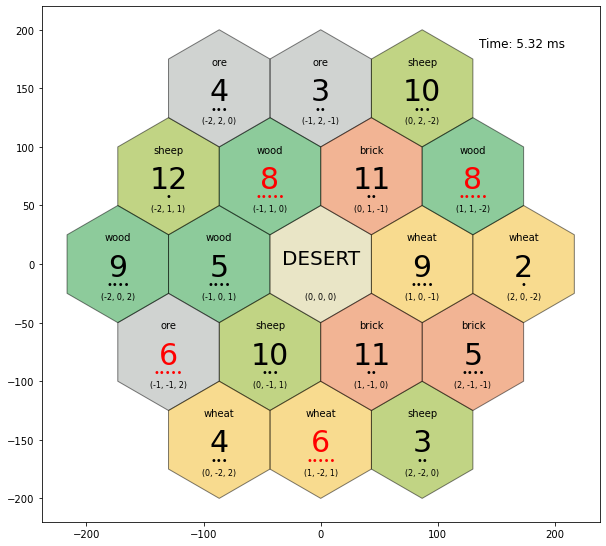

In [44]:
def hex_to_pixel(layout, h):
    M = layout.orientation.forward_matrix
    size = layout.size
    origin = layout.origin
    h_vector = np.array([h.q, h.r])
    xy = M @ h_vector 
    return Point(xy[0] * size.x + origin.x , xy[1] * size.y + origin.y )

def validate_tiles(hex_map):
    hex_dict = {(tile.q, tile.r): tile for tile in hex_map}
    for tile in hex_map:
        for i in range(6):
            neighbour = tile.get_neighbour(i)
            neighbor_tile = hex_dict.get((neighbour.q, neighbour.r))
            
            if neighbor_tile:
                if tile.token == neighbor_tile.token:
                    return False
                if (tile.token == 6 and neighbor_tile.token == 8) or (tile.token == 8 and neighbor_tile.token == 6):
                    return False
    return True

def start_validation(hex_map):
    legal = False
    iteration = 0
    start_time = time.time()
    
    while not legal:
        iteration += 1
        tokens = ['2'] + ['3'] * 2 + ['4'] * 2 + ['5'] * 2 + ['6'] * 2 + ['8'] * 2 + ['9'] * 2 + ['10'] * 2 + ['11'] * 2 + ['12']
        tokenised_map = hex_map.copy()
        
        for hex in tokenised_map:
            if hex.resource == 'desert':
                continue
            random.shuffle(tokens)
            token = tokens.pop()
            hex.set_token(int(token))

        legal = validate_tiles(tokenised_map)
    
    end_time = time.time()
    duration = end_time - start_time
    
    return tokenised_map, iteration, duration

def plot_hex_map(hex_map, iterations, duration):
    plt.figure(figsize=(10, 10))
    layout = Layout(layout_pointy, Point(50, 50), Point(0, 0))
    token_counts = Counter(hex.token for hex in hex_map if hex.resource != 'desert')
    resource_counts = Counter(hex.resource for hex in hex_map)
    map_size = len(hex_map)

    for hex in hex_map:
        corners = polygon_corners(layout, hex)
        xs = [corner.x for corner in corners]
        ys = [corner.y for corner in corners]
        plt.fill(xs, ys, get_tile_colour(hex.resource), edgecolor='black', alpha=0.5)

        center_x = sum(xs) / len(xs)
        center_y = sum(ys) / len(ys)

        if hex.resource == 'desert':
            plt.text(center_x, center_y, "DESERT", ha='center', fontsize=20)
            plt.text(center_x, center_y - 30, f"({hex.q}, {hex.r}, {hex.s})", ha='center', fontsize=8)
        else:
            scarcity = scarcity_map.get(hex.token, 1)
            dots = "•" * scarcity
            color = 'red' if scarcity == 5 else 'black'

            plt.text(center_x, center_y + 20, hex.resource, ha='center', fontsize=10)
            plt.text(center_x, center_y - 10, hex.token, color=color, ha='center', fontsize=30)
            plt.text(center_x, center_y - 20, dots, color=color, ha='center', fontsize=10)
            plt.text(center_x, center_y - 30, f"({hex.q}, {hex.r}, {hex.s})", ha='center', fontsize=8)

    plt.text(2.7 * 50, 3.7 * 50, f"Time: {duration*1000:.2f} ms", fontsize=12)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

N = 2  
hex_map = set()
hex_search_ez = {}
scarcity_map = {
    2: 1, 3: 2, 4: 3, 5: 4, 6: 5,
    8: 5, 9: 4, 10: 3, 11: 2, 12: 1
}
scarcity_map.get(11)

while hex_search_ez.get("0,0") is None or hex_search_ez["0,0"].resource != 'desert':
    hex_map.clear() 
    hex_search_ez.clear()  

    resources = ['wood'] * 4 + ['sheep'] * 4 + ['wheat'] * 4 + ['brick'] * 3 + ['ore'] * 3 + ['desert']
    for q in range(-N, N + 1):
        r1 = max(-N, -q - N)
        r2 = min(N, -q + N)
        random.shuffle(resources)
        for r in range(r1, r2 + 1):
            resource = resources.pop()
            hex_tile = Hex(q, r, resource)
            hex_map.add(hex_tile)
            hex_search_ez[f"{q},{r}"] = hex_tile
hex_map, iterations, duration = start_validation(hex_map)
plot_hex_map(hex_map, iterations, duration)